# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.applications.mobilenet import preprocess_input

### Change directory

In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/GreatLearning/Lab/Lab9/")

### Load the training data from train.csv file

In [0]:
#Read csv file as pandas dataframe
train_df = pd.read_csv('train_labels.csv')

### Print the shape of the train dataset

In [231]:
train_df.shape

(173, 8)

In [232]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
 # Set the file-path for the images 
 train_df['file_path']= "images/" + train_df['filename']

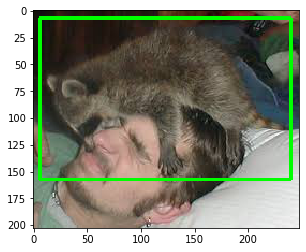

In [235]:
#Pickup a random image number
img_num = np.random.randint(0, train_df.shape[0])

#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(train_df.loc[img_num,'file_path'])
cv2.rectangle(img, 
             (train_df.loc[img_num, 'xmin'],train_df.loc[img_num, 'ymin']),
             (train_df.loc[img_num, 'xmax'],train_df.loc[img_num, 'ymax']), 
             (0,255,0),
             2)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(img)
plt.show()

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
# Set the Image-Size to what was defined ealier 
img_size = IMAGE_SIZE

In [0]:
# Use the batch generator to do the below tasks:
# Images: Read the Image-File into a numpy-array, reshape to 128*128*3, return a batch-set of batch_images 
# Bounding-Boxes: Get the batch-set of bounding-boxes adjusted to the reshaped-image and with coord (xmin, ymin, width, height)
def batch_generator(df, batch_size=32):

    while True:
        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, img_size, img_size, 3))
       
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'file_path'], 
                                                        target_size=(img_size, img_size))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array

            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * img_size/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * img_size/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * img_size/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * img_size/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        batch_images = preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/img_size

        #Return batch - use yield function to make it a python generator
        yield batch_images, batch_bboxes

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from tensorflow.python.keras.applications.mobilenet import MobileNet

In [0]:
tf.keras.backend.clear_session()
model = MobileNet(include_top=False, #Do not include FC layer at the end
                      input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3),
                      weights='imagenet')

In [0]:
#model.summary()

In [0]:
# Freeze all the layers
for layer in model.layers:
    layer.trainable = False

In [0]:
#get Output layer of Pre-trained model
x = model.output

# Add a convolution layer and batchnorm
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

#Flatten the output to feed to Dense layer
x = tf.keras.layers.Flatten()(x)

#Add Dropout
x = tf.keras.layers.Dropout(0.5)(x)

#Regression
bbox_output = tf.keras.layers.Dense(4 , activation='sigmoid', name='reg_op')(x)

In [0]:
# Create a final-model with mobilenet and additional layers with output of bounding-box with 4 co-ordinates 
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs= [bbox_output]) #Output layer added

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#    Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tf.compat.v1.keras.backend.epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
final_model.compile(optimizer='adam', 
                    loss={'reg_op':'mse'},
                    loss_weights={'reg_op':1},
                    metrics=[IoU])
#final_model.summary()

In [0]:
#Create train-generation with batch-size of 32 
batchsize = 32
train_generator = batch_generator(train_df, batch_size=batchsize)

In [247]:
# fit-generator with epochs of 30 and verbose
final_model.fit_generator(train_generator, 
                          epochs=30,
                          steps_per_epoch= train_df.shape[0]/batchsize,
                          verbose=1)

Epoch 1/30
6/5 [=================================] - 9s 2s/step - loss: 0.0973 - IoU: 0.3665
Epoch 2/30
6/5 [=================================] - 7s 1s/step - loss: 0.0564 - IoU: 0.5012
Epoch 3/30
6/5 [=================================] - 7s 1s/step - loss: 0.0448 - IoU: 0.5483
Epoch 4/30
6/5 [=================================] - 7s 1s/step - loss: 0.0448 - IoU: 0.5546
Epoch 5/30
6/5 [=================================] - 7s 1s/step - loss: 0.0404 - IoU: 0.5622
Epoch 6/30
6/5 [=================================] - 7s 1s/step - loss: 0.0405 - IoU: 0.5137
Epoch 7/30
6/5 [=================================] - 7s 1s/step - loss: 0.0375 - IoU: 0.5396
Epoch 8/30
6/5 [=================================] - 7s 1s/step - loss: 0.0334 - IoU: 0.5878
Epoch 9/30
6/5 [=================================] - 7s 1s/step - loss: 0.0310 - IoU: 0.6010
Epoch 10/30
6/5 [=================================] - 7s 1s/step - loss: 0.0384 - IoU: 0.5413
Epoch 11/30
6/5 [=================================] - 7s 1s/step - lo

In [0]:
final_model.save('mobnet_dataset_localization.h5')

### Pick a test image from the given data, Resize to 128*128, Predict the Bounding-Box co-ordinates, show the image and the bouding-box


In [0]:
# Function to predict the bounding-box and draw the original and predicted bounding-box for a given test-image 
def predict_and_draw(image_num, df):

    #Load image
    img = tf.keras.preprocessing.image.load_img(df.loc[image_num, 'file_path'])
    w, h = img.size

    #Read bounding box
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]
    
    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((img_size, img_size)) 
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)
    #3. Normalize image data
    input_array = preprocess_input(input_array)

    #Prediction
    pred = final_model.predict(input_array)
    bbox_pred = pred[0]

    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'file_path'])
    #Draw actual bounding box
    img = cv2.rectangle(img, (xmin, ymin), 
                       (xmax, ymax), (0,0,255), 2)
    #Draw predicted bounding box
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 2)

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

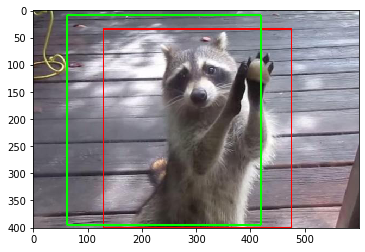

In [253]:
#Predict on Test Dataset
image_num = np.random.randint(0, train_df.shape[0])
predict_and_draw(image_num, train_df)